In [10]:
! pwd
! pip uninstall sympytorch -y

/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning


Found existing installation: sympytorch 0.1.4
Uninstalling sympytorch-0.1.4:
  Successfully uninstalled sympytorch-0.1.4


In [12]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"
#ROOT="/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

In [13]:
from Train_differentiable_physics_with_PINNs import PINNS_based_SOL_trainer

In [119]:
from random import randint
from Physical_models.Differentiable_simulation import Space2Tensor,Tensor2Space
from tqdm import tqdm


class PINNS_based_SOL_trainer(PINNS_based_SOL_trainer):
    def __init__(self,field,physical_model,statistical_model,optimizer,simulation_steps,time_step,loss):

      self.dt=time_step
      self.v=field
      self.physical_model_constructor=physical_model

      self.ph_model=physical_model(self.v,dt=self.dt)

      self.init_states_gt=[self.v]


      self.n_steps=simulation_steps
      self.st_model=statistical_model
      self.loss=loss
      self.optimizer=optimizer

      self.geometry=self.v.geometry

    def generate_postion_time_code(self,field):  # Re implement if more dimensions are needed
      X=field.geometry.center.native("x,y")
      XT=rearrange(X,"x y c -> c x y").unsqueeze(0)

      return XT
    
    def forward_prediction_correction(self):

      # FIELD FORMAT
      self.os_=self.v.geometry.center.native("x,y").shape
      # SQUARED TENSOR FORMAT
      XT=self.generate_postion_time_code(self.v)
      XTU=torch.concat((XT,Space2Tensor(self.v,self.geometry)),axis=1)

      # TABULAR TENSOR FORMAT
      states_pred=[rearrange(XTU,"b u x y-> b (x y) u").requires_grad_(True)]  # START OF FLUX
      XTUp_1,XTUp=self.correct(states_pred[-1])
      
      # OBS: correction is made in field forrmat, for no aparent reason (TODO: try to train in field format)
      states_in=[XTUp_1]
      states_corr=[XTUp]
      states_pred=[XTUp_1[:,:,-1:]+XTUp]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in range(self.n_steps):
        
        # Step last in states_pred
        U_space=Tensor2Space(rearrange(states_pred[-1]," b (x y) u -> b u x y",x=self.os_[0],y=self.os_[1])[0],self.geometry)
        states_pred.append(self.ph_model.step(
          U_space
          ))
        #U_tensor=Space2Tensor(U_space,self.geometry)
        #=self.t+self.dt
        XT=self.generate_postion_time_code(U_space)
        XTU=torch.concat((XT,Space2Tensor(U_space,self.geometry)),axis=1)
        # GRAD HERE
        
        states_pred[-1]=rearrange(XTU,"b u x y-> b (x y) u")
        # Correct with model of last states_pred
        XTUp_1,XTUp=self.correct(states_pred[-1])

        states_in.append(XTUp_1)
        states_corr.append(XTUp)
        states_pred[-1]=XTUp_1[:,:,-1:]+XTUp

      return states_pred,states_corr,states_in
    
    def forward_prediction_correction_test(self):

      # FIELD FORMAT
      self.os_=self.v.geometry.center.native("x,y").shape
      # SQUARED TENSOR FORMAT
      XT=self.generate_postion_time_code(self.v)
      XTU=torch.concat((XT,Space2Tensor(self.v,self.geometry)),axis=1)

      # TABULAR TENSOR FORMAT
      states_pred=[rearrange(XTU,"b u x y-> b (x y) u").requires_grad_(True)]  # START OF FLUX
      XTUp_1,XTUp=self.correct(states_pred[-1])
      
      # OBS: correction is made in field forrmat, for no aparent reason (TODO: try to train in field format)
      states_in=[XTUp_1]
      states_corr=[XTUp]
      states_pred=[XTUp_1[:,:,-1:]+XTUp]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in tqdm(range(self.n_steps_test)):
        
        # Step last in states_pred
        U_space=Tensor2Space(rearrange(states_pred[-1]," b (x y) u -> b u x y",x=self.os_[0],y=self.os_[1])[0],self.geometry)
        states_pred.append(self.ph_model.step(
          U_space
          ))
        #U_tensor=Space2Tensor(U_space,self.geometry)
        #self.t=self.t+self.dt
        XT=self.generate_postion_time_code(U_space,self.t)
        XTU=torch.concat((XT,Space2Tensor(U_space,self.geometry)),axis=1)
        # GRAD HERE
        
        states_pred[-1]=rearrange(XTU,"b u x y-> b (x y) u")
        # Correct with model of last states_pred
        XTUp_1,XTUp=self.correct(states_pred[-1])

        states_in.append(XTUp_1)
        states_corr.append(XTUp)
        states_pred[-1]=XTUp_1[:,:,-1:]+XTUp

      return states_pred,states_corr,states_in
    
    def train(self,epochs):
      losses=[]
      for i in tqdm(range(epochs)):
        #tqdm.write(f"epoch {i}")
        co_batch=[]
        in_batch=[]
        for b in tqdm(range(5)):
          #tqdm.write(f"batch {b}")

          random_idx=randint(0,len(self.init_states_gt)-1)
          self.v=self.detach_field(self.init_states_gt[random_idx])
          #self.t=self.T[random_idx]
          states_pred,states_corr,states_in=self.forward_prediction_correction()
          co_batch=co_batch+states_pred
          in_batch=in_batch+states_in

        loss=0
        for i,(u,x) in enumerate(zip(co_batch,in_batch)):
          #print(u)
          #print(x)
          sample_loss=self.loss(u,x)
          loss=loss+sample_loss


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        loss=loss/self.n_steps
        losses.append(loss.cpu().detach().numpy())
      return losses
    
    def test(self,epochs, time_fine_frac,space_fine_frac,coarse_solver):

      # Coarser spatial discretization
      self.ph_model=self.physical_model_constructor(self.v.downsample(1/space_fine_frac),dt=self.dt)
      # Coarser temporal discretization
      #self.n_steps_test=max((int(self.n_steps*time_fine_frac),1))
      self.n_steps_test=int(self.n_steps*time_fine_frac)
      or_dt=self.ph_model.dt
      self.ph_model.dt=self.ph_model.dt/time_fine_frac
      self.dt=self.ph_model.dt/time_fine_frac
      # coarser solver
      self.ph_model.solver_=coarse_solver
      self.st_model.eval()

      

      losses=[]
      for i in tqdm(range(epochs)):
        #tqdm.write(f"epoch {i}")
        co_batch=[]
        in_batch=[]
        for b in tqdm(range(20)):
          #tqdm.write(f"batch {b}")

          random_idx=randint(0,len(self.init_states_gt)-1)
          self.v=self.detach_field(self.init_states_gt[random_idx])
          #self.t=self.T[random_idx]
          states_pred,states_corr,states_in=self.forward_prediction_correction_test()
          co_batch=co_batch+states_pred
          in_batch=in_batch+states_in

        loss=0
        for i,(u,x) in enumerate(zip(co_batch,in_batch)):
          #print("test")
          #print(u)
          #print(x)
          sample_loss=self.loss(u,x)
          loss=loss+sample_loss

        loss=loss/self.n_steps_test
        losses.append(loss.cpu().detach().numpy())
      
      self.ph_model.dt=or_dt
      self.dt=or_dt
      return losses

## Poisson

$$ - \nabla \cdot ( a(x) \nabla u ) = f $$

### Solver

In [120]:
from phi.torch.flow import *
from phi.field import laplace
class poisson_model(object):
  def __init__(self,field,dt,solver= lambda x: Solve(x0=x),conductivity=0.3):
    self.field=field
    self.dt=dt
    self.conductivity=conductivity
    self.solver_=solver

  def explicit_step(self, v):
    lap = laplace(v, 
                  weights=self.conductivity, 
                  order=2, 
                  implicit=math.Solve,
                  correct_skew=False
                  )
    return lap.with_extrapolation(v.boundary - v.boundary)  # remove constants from extrapolation
  def step(self,v):
    def sharpen(x):
      return self.explicit_step(x)
    return math.solve_linear(sharpen, y=v, solve=self.solver_(v))


In [121]:
geo=UniformGrid(x=50, y=50,bounds=Box(x=1.0, y=1.0))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': tensor(0.3),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })
phi_w



model=poisson_model(phi_w,
                    0.1,
                    )

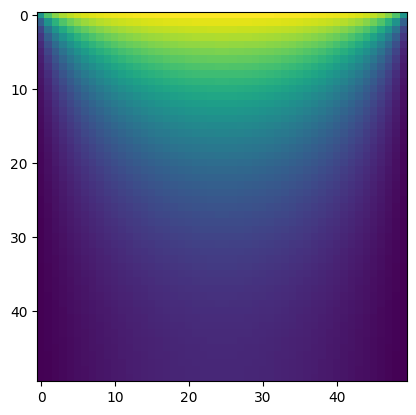

In [122]:
import matplotlib.pyplot as plt
plt.imshow(model.step(phi_w).values.native("x,y").numpy())

In [127]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from DL_models.PINNS.utils import *

class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(3, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 1, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*0.01
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x
  

#class composed_loss(object):

#from DL_models.PINNS.utils import x_grad

def composed_loss(p,x):
  """
  u: [b x y p]
  x: [b x y (x y t)]
  """
  #p=rearrange(p,"b p x y-> b (x y) p")
  #x=rearrange(x,"b u x y-> b (x y) u")
  #dpdt=x_grad(p,x,0,1)[...,2]
  lap_u=torch.sum(x_grad(p,x,0,2)[...,:2],axis=-1)
  k=0.1#*torch.exp(
    #-torch.sum(((x[...,:2]-torch.mean(x[...,:2]))**2),axis=(1,2))/(2*0.5))

  return torch.abs(torch.mean(-k*lap_u))

st_model=simple_cnn_model().train()

optimizer=torch.optim.Adam(st_model.parameters(),lr=1e-4)

def composed_loss(p,x,conductivity=0.3):
  """
  u: [b x y p]
  x: [b x y (x y t)]
  """
  #p=rearrange(p,"b p x y-> b (x y) p")
  #x=rearrange(x,"b u x y-> b (x y) u")
  #dpdt = x_grad(p,x,0,1)[...,2]
  x_1_grad = x_grad(p,x,0,1)[...,:2] # r
  con_tensor=torch.eye(2,2)*conductivity # [2, 2]
  k=torch.tensordot(con_tensor,x_1_grad,dims=([-1],[2]))
  x_2_grad = torch.sum(x_grad(p,x,0,1)[...,:2],axis=-1) # r

  return torch.abs(torch.mean(-k*x_2_grad))

In [128]:
T=PINNS_based_SOL_trainer(
    field=phi_w,
    physical_model=poisson_model,
    statistical_model=st_model,
    optimizer=optimizer,
    simulation_steps=0,
    time_step=0.5,
    loss=composed_loss
)

In [129]:
from tqdm import tqdm
L_tr=[]
L_ts=[]

In [130]:
for i in tqdm(range(200)):
    print("train step")
    L_tr.append(T.train(1))
    print("test step")
    L_ts.append(T.test(1,time_fine_frac=0.5,space_fine_frac=0.5,coarse_solver=lambda x: Solve( x0=x,rel_tol=1e-00, abs_tol=1e-00,max_iterations=100)))
    tqdm.write(f"train {L_tr[-1]},test {L_ts[-1]}")

  0%|          | 0/200 [00:00<?, ?it/s]

train step



100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


tensor([[[-2.2044e-05],
         [-1.2409e-05],
         [ 3.5147e-06],
         ...,
         [ 2.3945e-04],
         [ 3.2220e-04],
         [ 1.7802e-04]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.2044e-05],
         [-1.2409e-05],
         [ 3.5147e-06],
         ...,
         [ 2.3945e-04],
         [ 3.2220e-04],
         [ 1.7802e-04]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.2044e-05],
         [-1.2409e-05],
         [ 3.5147e-06],
         ...,
         [ 2.3945e-04],
         [ 3.2220e-04],
      




0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  0%|          | 1/200 [00:00<01:28,  2.25it/s]

test
tensor([[[-2.7694e-05],
         [-2.1587e-05],
         [-8.8039e-06],
         ...,
         [-1.1604e-05],
         [ 1.1483e-04],
         [ 2.8855e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.7694e-05],
         [-2.1587e-05],
         [-8.8039e-06],
         ...,
         [-1.1604e-05],
         [ 1.1483e-04],
         [ 2.8855e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.7694e-05],
         [-2.1587e-05],
         [-8.8039e-06],
         ...,
         [-1.1604e-05],
         [ 1.14


100%|██████████| 5/5 [00:00<00:00, 285.65it/s]


tensor([[[-2.7694e-05],
         [-2.1587e-05],
         [-8.8039e-06],
         ...,
         [-1.1604e-05],
         [ 1.1483e-04],
         [ 2.8855e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.7694e-05],
         [-2.1587e-05],
         [-8.8039e-06],
         ...,
         [-1.1604e-05],
         [ 1.1483e-04],
         [ 2.8855e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.7694e-05],
         [-2.1587e-05],
         [-8.8039e-06],
         ...,
         [-1.1604e-05],
         [ 1.1483e-04],
      

100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 108.26it/s]


test
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
         [ 1.7886e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
         [ 1.7886e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.10

  1%|          | 2/200 [00:00<01:27,  2.27it/s]

test
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
         [ 1.7886e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
         [ 1.7886e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.10


100%|██████████| 5/5 [00:00<00:00, 288.86it/s]


tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
         [ 1.7886e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
         [ 1.7886e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.9064e-05],
         [-2.3491e-05],
         [-1.1940e-05],
         ...,
         [-3.8551e-05],
         [ 9.1011e-05],
      

100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 106.56it/s]


test
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
         [ 4.4459e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
         [ 4.4459e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.26

  2%|▏         | 3/200 [00:01<01:34,  2.09it/s]

test
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
         [ 4.4459e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
         [ 4.4459e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.26


100%|██████████| 5/5 [00:00<00:00, 283.91it/s]


tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
         [ 4.4459e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
         [ 4.4459e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-2.9676e-05],
         [-2.3263e-05],
         [-1.2221e-05],
         ...,
         [-9.0482e-07],
         [ 1.2627e-04],
      

100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  2%|▏         | 4/200 [00:01<01:30,  2.17it/s]

test
tensor([[[-3.0537e-05],
         [-2.3185e-05],
         [-1.2498e-05],
         ...,
         [ 4.3028e-05],
         [ 1.6219e-04],
         [ 7.5676e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.0537e-05],
         [-2.3185e-05],
         [-1.2498e-05],
         ...,
         [ 4.3028e-05],
         [ 1.6219e-04],
         [ 7.5676e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.0537e-05],
         [-2.3185e-05],
         [-1.2498e-05],
         ...,
         [ 4.3028e-05],
         [ 1.62


100%|██████████| 5/5 [00:00<00:00, 285.31it/s]


tensor([[[-3.0537e-05],
         [-2.3185e-05],
         [-1.2498e-05],
         ...,
         [ 4.3028e-05],
         [ 1.6219e-04],
         [ 7.5676e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.0537e-05],
         [-2.3185e-05],
         [-1.2498e-05],
         ...,
         [ 4.3028e-05],
         [ 1.6219e-04],
         [ 7.5676e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.0537e-05],
         [-2.3185e-05],
         [-1.2498e-05],
         ...,
         [ 4.3028e-05],
         [ 1.6219e-04],
      

100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 104.37it/s]


test
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
         [ 9.3559e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
         [ 9.3559e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.87

  2%|▎         | 5/200 [00:02<01:28,  2.21it/s]

tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
         [ 9.3559e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
         [ 9.3559e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-0


100%|██████████| 5/5 [00:00<00:00, 288.84it/s]


tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
         [ 9.3559e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
         [ 9.3559e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.1839e-05],
         [-2.3810e-05],
         [-1.3022e-05],
         ...,
         [ 7.3296e-05],
         [ 1.8789e-04],
      

100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

  3%|▎         | 6/200 [00:02<01:28,  2.19it/s]

test
tensor([[[-3.3558e-05],
         [-2.5217e-05],
         [-1.4632e-05],
         ...,
         [ 8.8437e-05],
         [ 1.9622e-04],
         [ 9.9757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.3558e-05],
         [-2.5217e-05],
         [-1.4632e-05],
         ...,
         [ 8.8437e-05],
         [ 1.9622e-04],
         [ 9.9757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.3558e-05],
         [-2.5217e-05],
         [-1.4632e-05],
         ...,
         [ 8.8437e-05],
         [ 1.96


100%|██████████| 5/5 [00:00<00:00, 282.28it/s]


tensor([[[-3.3558e-05],
         [-2.5217e-05],
         [-1.4632e-05],
         ...,
         [ 8.8437e-05],
         [ 1.9622e-04],
         [ 9.9757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.3558e-05],
         [-2.5217e-05],
         [-1.4632e-05],
         ...,
         [ 8.8437e-05],
         [ 1.9622e-04],
         [ 9.9757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.3558e-05],
         [-2.5217e-05],
         [-1.4632e-05],
         ...,
         [ 8.8437e-05],
         [ 1.9622e-04],
      

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 115.85it/s]


test
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
         [ 9.7661e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
         [ 9.7661e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.92

  4%|▎         | 7/200 [00:03<01:48,  1.78it/s]

test
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
         [ 9.7661e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
         [ 9.7661e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.92


100%|██████████| 5/5 [00:00<00:00, 267.88it/s]


tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
         [ 9.7661e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
         [ 9.7661e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.5386e-05],
         [-2.7211e-05],
         [-1.7153e-05],
         ...,
         [ 8.7255e-05],
         [ 1.9221e-04],
      

100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

  4%|▍         | 8/200 [00:03<01:40,  1.91it/s]

test
tensor([[[-3.7302e-05],
         [-2.9394e-05],
         [-2.0056e-05],
         ...,
         [ 7.5473e-05],
         [ 1.7833e-04],
         [ 9.0562e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.7302e-05],
         [-2.9394e-05],
         [-2.0056e-05],
         ...,
         [ 7.5473e-05],
         [ 1.7833e-04],
         [ 9.0562e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.7302e-05],
         [-2.9394e-05],
         [-2.0056e-05],
         ...,
         [ 7.5473e-05],
         [ 1.78


100%|██████████| 5/5 [00:00<00:00, 283.15it/s]


tensor([[[-3.7302e-05],
         [-2.9394e-05],
         [-2.0056e-05],
         ...,
         [ 7.5473e-05],
         [ 1.7833e-04],
         [ 9.0562e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.7302e-05],
         [-2.9394e-05],
         [-2.0056e-05],
         ...,
         [ 7.5473e-05],
         [ 1.7833e-04],
         [ 9.0562e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.7302e-05],
         [-2.9394e-05],
         [-2.0056e-05],
         ...,
         [ 7.5473e-05],
         [ 1.7833e-04],
      

100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  4%|▍         | 9/200 [00:04<01:39,  1.93it/s]

test
tensor([[[-3.9174e-05],
         [-3.1765e-05],
         [-2.2738e-05],
         ...,
         [ 5.8910e-05],
         [ 1.5905e-04],
         [ 8.0076e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.9174e-05],
         [-3.1765e-05],
         [-2.2738e-05],
         ...,
         [ 5.8910e-05],
         [ 1.5905e-04],
         [ 8.0076e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-3.9174e-05],
         [-3.1765e-05],
         [-2.2738e-05],
         ...,
         [ 5.8910e-05],
         [ 1.59


100%|██████████| 5/5 [00:00<00:00, 282.18it/s]


tensor([[[-3.9174e-05],
         [-3.1765e-05],
         [-2.2738e-05],
         ...,
         [ 5.8910e-05],
         [ 1.5905e-04],
         [ 8.0076e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.9174e-05],
         [-3.1765e-05],
         [-2.2738e-05],
         ...,
         [ 5.8910e-05],
         [ 1.5905e-04],
         [ 8.0076e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-3.9174e-05],
         [-3.1765e-05],
         [-2.2738e-05],
         ...,
         [ 5.8910e-05],
         [ 1.5905e-04],
      

100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

  5%|▌         | 10/200 [00:04<01:34,  2.02it/s]

test
tensor([[[-4.0813e-05],
         [-3.4044e-05],
         [-2.5144e-05],
         ...,
         [ 4.0262e-05],
         [ 1.3991e-04],
         [ 6.9970e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.0813e-05],
         [-3.4044e-05],
         [-2.5144e-05],
         ...,
         [ 4.0262e-05],
         [ 1.3991e-04],
         [ 6.9970e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.0813e-05],
         [-3.4044e-05],
         [-2.5144e-05],
         ...,
         [ 4.0262e-05],
         [ 1.39


100%|██████████| 5/5 [00:00<00:00, 285.46it/s]


tensor([[[-4.0813e-05],
         [-3.4044e-05],
         [-2.5144e-05],
         ...,
         [ 4.0262e-05],
         [ 1.3991e-04],
         [ 6.9970e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.0813e-05],
         [-3.4044e-05],
         [-2.5144e-05],
         ...,
         [ 4.0262e-05],
         [ 1.3991e-04],
         [ 6.9970e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.0813e-05],
         [-3.4044e-05],
         [-2.5144e-05],
         ...,
         [ 4.0262e-05],
         [ 1.3991e-04],
      

100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  6%|▌         | 11/200 [00:05<01:30,  2.10it/s]

test
tensor([[[-4.2349e-05],
         [-3.6152e-05],
         [-2.7410e-05],
         ...,
         [ 2.3262e-05],
         [ 1.2410e-04],
         [ 6.0539e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.2349e-05],
         [-3.6152e-05],
         [-2.7410e-05],
         ...,
         [ 2.3262e-05],
         [ 1.2410e-04],
         [ 6.0539e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.2349e-05],
         [-3.6152e-05],
         [-2.7410e-05],
         ...,
         [ 2.3262e-05],
         [ 1.24


100%|██████████| 5/5 [00:00<00:00, 286.68it/s]


tensor([[[-4.2349e-05],
         [-3.6152e-05],
         [-2.7410e-05],
         ...,
         [ 2.3262e-05],
         [ 1.2410e-04],
         [ 6.0539e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.2349e-05],
         [-3.6152e-05],
         [-2.7410e-05],
         ...,
         [ 2.3262e-05],
         [ 1.2410e-04],
         [ 6.0539e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.2349e-05],
         [-3.6152e-05],
         [-2.7410e-05],
         ...,
         [ 2.3262e-05],
         [ 1.2410e-04],
      

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  6%|▌         | 12/200 [00:05<01:29,  2.11it/s]

test
tensor([[[-4.3906e-05],
         [-3.7979e-05],
         [-2.9464e-05],
         ...,
         [ 9.2628e-06],
         [ 1.1120e-04],
         [ 5.1250e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.3906e-05],
         [-3.7979e-05],
         [-2.9464e-05],
         ...,
         [ 9.2628e-06],
         [ 1.1120e-04],
         [ 5.1250e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.3906e-05],
         [-3.7979e-05],
         [-2.9464e-05],
         ...,
         [ 9.2628e-06],
         [ 1.11


100%|██████████| 5/5 [00:00<00:00, 285.58it/s]


tensor([[[-4.3906e-05],
         [-3.7979e-05],
         [-2.9464e-05],
         ...,
         [ 9.2628e-06],
         [ 1.1120e-04],
         [ 5.1250e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.3906e-05],
         [-3.7979e-05],
         [-2.9464e-05],
         ...,
         [ 9.2628e-06],
         [ 1.1120e-04],
         [ 5.1250e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.3906e-05],
         [-3.7979e-05],
         [-2.9464e-05],
         ...,
         [ 9.2628e-06],
         [ 1.1120e-04],
      

100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 115.20it/s]


test
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
         [ 4.3279e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
         [ 4.3279e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.01

  6%|▋         | 13/200 [00:06<01:25,  2.18it/s]

test
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
         [ 4.3279e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
         [ 4.3279e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.01


100%|██████████| 5/5 [00:00<00:00, 285.11it/s]


tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
         [ 4.3279e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
         [ 4.3279e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.5430e-05],
         [-3.9590e-05],
         [-3.1325e-05],
         ...,
         [-9.4072e-07],
         [ 1.0136e-04],
      

100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  7%|▋         | 14/200 [00:06<01:25,  2.18it/s]

test
tensor([[[-4.6898e-05],
         [-4.1045e-05],
         [-3.2997e-05],
         ...,
         [-7.1218e-06],
         [ 9.4241e-05],
         [ 3.6879e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.6898e-05],
         [-4.1045e-05],
         [-3.2997e-05],
         ...,
         [-7.1218e-06],
         [ 9.4241e-05],
         [ 3.6879e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.6898e-05],
         [-4.1045e-05],
         [-3.2997e-05],
         ...,
         [-7.1218e-06],
         [ 9.42


100%|██████████| 5/5 [00:00<00:00, 283.57it/s]


tensor([[[-4.6898e-05],
         [-4.1045e-05],
         [-3.2997e-05],
         ...,
         [-7.1218e-06],
         [ 9.4241e-05],
         [ 3.6879e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.6898e-05],
         [-4.1045e-05],
         [-3.2997e-05],
         ...,
         [-7.1218e-06],
         [ 9.4241e-05],
         [ 3.6879e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.6898e-05],
         [-4.1045e-05],
         [-3.2997e-05],
         ...,
         [-7.1218e-06],
         [ 9.4241e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  8%|▊         | 15/200 [00:07<01:23,  2.21it/s]

test
tensor([[[-4.8325e-05],
         [-4.2360e-05],
         [-3.4418e-05],
         ...,
         [-9.9254e-06],
         [ 8.8930e-05],
         [ 3.2018e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.8325e-05],
         [-4.2360e-05],
         [-3.4418e-05],
         ...,
         [-9.9254e-06],
         [ 8.8930e-05],
         [ 3.2018e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.8325e-05],
         [-4.2360e-05],
         [-3.4418e-05],
         ...,
         [-9.9254e-06],
         [ 8.89


100%|██████████| 5/5 [00:00<00:00, 287.04it/s]


tensor([[[-4.8325e-05],
         [-4.2360e-05],
         [-3.4418e-05],
         ...,
         [-9.9254e-06],
         [ 8.8930e-05],
         [ 3.2018e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.8325e-05],
         [-4.2360e-05],
         [-3.4418e-05],
         ...,
         [-9.9254e-06],
         [ 8.8930e-05],
         [ 3.2018e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.8325e-05],
         [-4.2360e-05],
         [-3.4418e-05],
         ...,
         [-9.9254e-06],
         [ 8.8930e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
  8%|▊         | 16/200 [00:07<01:24,  2.17it/s]

test
tensor([[[-4.9695e-05],
         [-4.3530e-05],
         [-3.5644e-05],
         ...,
         [-9.8242e-06],
         [ 8.4807e-05],
         [ 2.9246e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.9695e-05],
         [-4.3530e-05],
         [-3.5644e-05],
         ...,
         [-9.8242e-06],
         [ 8.4807e-05],
         [ 2.9246e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-4.9695e-05],
         [-4.3530e-05],
         [-3.5644e-05],
         ...,
         [-9.8242e-06],
         [ 8.48


100%|██████████| 5/5 [00:00<00:00, 282.12it/s]


tensor([[[-4.9695e-05],
         [-4.3530e-05],
         [-3.5644e-05],
         ...,
         [-9.8242e-06],
         [ 8.4807e-05],
         [ 2.9246e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.9695e-05],
         [-4.3530e-05],
         [-3.5644e-05],
         ...,
         [-9.8242e-06],
         [ 8.4807e-05],
         [ 2.9246e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-4.9695e-05],
         [-4.3530e-05],
         [-3.5644e-05],
         ...,
         [-9.8242e-06],
         [ 8.4807e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 104.79it/s]


test
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
         [ 2.7312e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
         [ 2.7312e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.21

  8%|▊         | 17/200 [00:08<01:22,  2.21it/s]

test
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
         [ 2.7312e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
         [ 2.7312e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.21


100%|██████████| 5/5 [00:00<00:00, 278.23it/s]


tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
         [ 2.7312e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
         [ 2.7312e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.0980e-05],
         [-4.4586e-05],
         [-3.6715e-05],
         ...,
         [-6.8204e-06],
         [ 8.2183e-05],
      

100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 111.81it/s]


test
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
         [ 2.5909e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
         [ 2.5909e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.05

  9%|▉         | 18/200 [00:08<01:21,  2.23it/s]

tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
         [ 2.5909e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
         [ 2.5909e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-0


100%|██████████| 5/5 [00:00<00:00, 284.55it/s]


tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
         [ 2.5909e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
         [ 2.5909e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.2168e-05],
         [-4.5484e-05],
         [-3.7708e-05],
         ...,
         [-3.3654e-06],
         [ 8.0585e-05],
      

100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 106.31it/s]


test
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
         [ 2.4757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
         [ 2.4757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.96

 10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
         [ 2.4757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
         [ 2.4757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-0


100%|██████████| 5/5 [00:00<00:00, 282.14it/s]


tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
         [ 2.4757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
         [ 2.4757e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.3302e-05],
         [-4.6347e-05],
         [-3.8692e-05],
         ...,
         [ 1.0033e-06],
         [ 7.9621e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

test step






0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 107.56it/s]


test
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
         [ 2.3532e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
         [ 2.3532e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.80

 10%|█         | 20/200 [00:09<01:23,  2.15it/s]

test
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
         [ 2.3532e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
         [ 2.3532e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.80


100%|██████████| 5/5 [00:00<00:00, 284.30it/s]


tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
         [ 2.3532e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
         [ 2.3532e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.4431e-05],
         [-4.7299e-05],
         [-3.9724e-05],
         ...,
         [ 4.2844e-06],
         [ 7.8021e-05],
      

100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

test step






0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 10%|█         | 21/200 [00:09<01:22,  2.17it/s]

test
tensor([[[-5.5598e-05],
         [-4.8412e-05],
         [-4.0917e-05],
         ...,
         [ 4.9372e-06],
         [ 7.5491e-05],
         [ 2.1844e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.5598e-05],
         [-4.8412e-05],
         [-4.0917e-05],
         ...,
         [ 4.9372e-06],
         [ 7.5491e-05],
         [ 2.1844e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.5598e-05],
         [-4.8412e-05],
         [-4.0917e-05],
         ...,
         [ 4.9372e-06],
         [ 7.54


100%|██████████| 5/5 [00:00<00:00, 283.25it/s]


tensor([[[-5.5598e-05],
         [-4.8412e-05],
         [-4.0917e-05],
         ...,
         [ 4.9372e-06],
         [ 7.5491e-05],
         [ 2.1844e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.5598e-05],
         [-4.8412e-05],
         [-4.0917e-05],
         ...,
         [ 4.9372e-06],
         [ 7.5491e-05],
         [ 2.1844e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.5598e-05],
         [-4.8412e-05],
         [-4.0917e-05],
         ...,
         [ 4.9372e-06],
         [ 7.5491e-05],
      

100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 103.52it/s]


test
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
         [ 1.9259e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
         [ 1.9259e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.20

 11%|█         | 22/200 [00:10<01:19,  2.23it/s]

tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
         [ 1.9259e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
         [ 1.9259e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-0


100%|██████████| 5/5 [00:00<00:00, 283.48it/s]


tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
         [ 1.9259e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
         [ 1.9259e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.6830e-05],
         [-4.9694e-05],
         [-4.2317e-05],
         ...,
         [ 3.5005e-06],
         [ 7.2083e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 106.52it/s]


test
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
         [ 1.5580e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
         [ 1.5580e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.71

 12%|█▏        | 23/200 [00:10<01:18,  2.26it/s]

test
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
         [ 1.5580e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
         [ 1.5580e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.71


100%|██████████| 5/5 [00:00<00:00, 282.67it/s]


tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
         [ 1.5580e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
         [ 1.5580e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.8170e-05],
         [-5.1125e-05],
         [-4.3913e-05],
         ...,
         [ 1.7418e-07],
         [ 6.7185e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 12%|█▏        | 24/200 [00:11<01:18,  2.26it/s]

test
tensor([[[-5.9575e-05],
         [-5.2670e-05],
         [-4.5612e-05],
         ...,
         [-4.7317e-06],
         [ 6.1124e-05],
         [ 1.0955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.9575e-05],
         [-5.2670e-05],
         [-4.5612e-05],
         ...,
         [-4.7317e-06],
         [ 6.1124e-05],
         [ 1.0955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-5.9575e-05],
         [-5.2670e-05],
         [-4.5612e-05],
         ...,
         [-4.7317e-06],
         [ 6.11


100%|██████████| 5/5 [00:00<00:00, 284.73it/s]


tensor([[[-5.9575e-05],
         [-5.2670e-05],
         [-4.5612e-05],
         ...,
         [-4.7317e-06],
         [ 6.1124e-05],
         [ 1.0955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.9575e-05],
         [-5.2670e-05],
         [-4.5612e-05],
         ...,
         [-4.7317e-06],
         [ 6.1124e-05],
         [ 1.0955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-5.9575e-05],
         [-5.2670e-05],
         [-4.5612e-05],
         ...,
         [-4.7317e-06],
         [ 6.1124e-05],
      

100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 110.08it/s]


test
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
         [ 5.7914e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
         [ 5.7914e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.42

 12%|█▎        | 25/200 [00:11<01:20,  2.17it/s]

test
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
         [ 5.7914e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
         [ 5.7914e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.42


100%|██████████| 5/5 [00:00<00:00, 282.79it/s]


tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
         [ 5.7914e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
         [ 5.7914e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.0969e-05],
         [-5.4258e-05],
         [-4.7317e-05],
         ...,
         [-1.0802e-05],
         [ 5.4205e-05],
      

100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 13%|█▎        | 26/200 [00:12<01:19,  2.20it/s]

test
tensor([[[-6.2301e-05],
         [-5.5842e-05],
         [-4.8935e-05],
         ...,
         [-1.7399e-05],
         [ 4.6997e-05],
         [ 4.2571e-07]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.2301e-05],
         [-5.5842e-05],
         [-4.8935e-05],
         ...,
         [-1.7399e-05],
         [ 4.6997e-05],
         [ 4.2571e-07]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.2301e-05],
         [-5.5842e-05],
         [-4.8935e-05],
         ...,
         [-1.7399e-05],
         [ 4.69


100%|██████████| 5/5 [00:00<00:00, 283.67it/s]


tensor([[[-6.2301e-05],
         [-5.5842e-05],
         [-4.8935e-05],
         ...,
         [-1.7399e-05],
         [ 4.6997e-05],
         [ 4.2571e-07]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.2301e-05],
         [-5.5842e-05],
         [-4.8935e-05],
         ...,
         [-1.7399e-05],
         [ 4.6997e-05],
         [ 4.2571e-07]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.2301e-05],
         [-5.5842e-05],
         [-4.8935e-05],
         ...,
         [-1.7399e-05],
         [ 4.6997e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 14%|█▎        | 27/200 [00:12<01:18,  2.22it/s]

test
tensor([[[-6.3554e-05],
         [-5.7350e-05],
         [-5.0472e-05],
         ...,
         [-2.4210e-05],
         [ 3.9776e-05],
         [-4.8919e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.3554e-05],
         [-5.7350e-05],
         [-5.0472e-05],
         ...,
         [-2.4210e-05],
         [ 3.9776e-05],
         [-4.8919e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.3554e-05],
         [-5.7350e-05],
         [-5.0472e-05],
         ...,
         [-2.4210e-05],
         [ 3.97


100%|██████████| 5/5 [00:00<00:00, 284.72it/s]


tensor([[[-6.3554e-05],
         [-5.7350e-05],
         [-5.0472e-05],
         ...,
         [-2.4210e-05],
         [ 3.9776e-05],
         [-4.8919e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.3554e-05],
         [-5.7350e-05],
         [-5.0472e-05],
         ...,
         [-2.4210e-05],
         [ 3.9776e-05],
         [-4.8919e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.3554e-05],
         [-5.7350e-05],
         [-5.0472e-05],
         ...,
         [-2.4210e-05],
         [ 3.9776e-05],
      

100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

 14%|█▍        | 28/200 [00:13<01:32,  1.86it/s]

test
tensor([[[-6.4725e-05],
         [-5.8762e-05],
         [-5.1908e-05],
         ...,
         [-3.0822e-05],
         [ 3.2962e-05],
         [-9.9638e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.4725e-05],
         [-5.8762e-05],
         [-5.1908e-05],
         ...,
         [-3.0822e-05],
         [ 3.2962e-05],
         [-9.9638e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.4725e-05],
         [-5.8762e-05],
         [-5.1908e-05],
         ...,
         [-3.0822e-05],
         [ 3.29


100%|██████████| 5/5 [00:00<00:00, 285.57it/s]


tensor([[[-6.4725e-05],
         [-5.8762e-05],
         [-5.1908e-05],
         ...,
         [-3.0822e-05],
         [ 3.2962e-05],
         [-9.9638e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.4725e-05],
         [-5.8762e-05],
         [-5.1908e-05],
         ...,
         [-3.0822e-05],
         [ 3.2962e-05],
         [-9.9638e-06]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.4725e-05],
         [-5.8762e-05],
         [-5.1908e-05],
         ...,
         [-3.0822e-05],
         [ 3.2962e-05],
      

100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 14%|█▍        | 29/200 [00:13<01:34,  1.81it/s]

test
tensor([[[-6.5789e-05],
         [-6.0038e-05],
         [-5.3208e-05],
         ...,
         [-3.6995e-05],
         [ 2.7427e-05],
         [-1.4501e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.5789e-05],
         [-6.0038e-05],
         [-5.3208e-05],
         ...,
         [-3.6995e-05],
         [ 2.7427e-05],
         [-1.4501e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.5789e-05],
         [-6.0038e-05],
         [-5.3208e-05],
         ...,
         [-3.6995e-05],
         [ 2.74


100%|██████████| 5/5 [00:00<00:00, 286.44it/s]


tensor([[[-6.5789e-05],
         [-6.0038e-05],
         [-5.3208e-05],
         ...,
         [-3.6995e-05],
         [ 2.7427e-05],
         [-1.4501e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.5789e-05],
         [-6.0038e-05],
         [-5.3208e-05],
         ...,
         [-3.6995e-05],
         [ 2.7427e-05],
         [-1.4501e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.5789e-05],
         [-6.0038e-05],
         [-5.3208e-05],
         ...,
         [-3.6995e-05],
         [ 2.7427e-05],
      

100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 112.25it/s]


test
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
         [-1.8374e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
         [-1.8374e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.25

 15%|█▌        | 30/200 [00:14<01:36,  1.76it/s]

test
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
         [-1.8374e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
         [-1.8374e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.25


100%|██████████| 5/5 [00:00<00:00, 279.46it/s]


tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
         [-1.8374e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
         [-1.8374e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.6750e-05],
         [-6.1182e-05],
         [-5.4355e-05],
         ...,
         [-4.2328e-05],
         [ 2.2590e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

test step






0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 16%|█▌        | 31/200 [00:15<01:31,  1.85it/s]

test
tensor([[[-6.7616e-05],
         [-6.2188e-05],
         [-5.5363e-05],
         ...,
         [-4.6858e-05],
         [ 1.8686e-05],
         [-2.1465e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.7616e-05],
         [-6.2188e-05],
         [-5.5363e-05],
         ...,
         [-4.6858e-05],
         [ 1.8686e-05],
         [-2.1465e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.7616e-05],
         [-6.2188e-05],
         [-5.5363e-05],
         ...,
         [-4.6858e-05],
         [ 1.86


100%|██████████| 5/5 [00:00<00:00, 284.29it/s]


tensor([[[-6.7616e-05],
         [-6.2188e-05],
         [-5.5363e-05],
         ...,
         [-4.6858e-05],
         [ 1.8686e-05],
         [-2.1465e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.7616e-05],
         [-6.2188e-05],
         [-5.5363e-05],
         ...,
         [-4.6858e-05],
         [ 1.8686e-05],
         [-2.1465e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.7616e-05],
         [-6.2188e-05],
         [-5.5363e-05],
         ...,
         [-4.6858e-05],
         [ 1.8686e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 16%|█▌        | 32/200 [00:15<01:26,  1.95it/s]

test
tensor([[[-6.8397e-05],
         [-6.3053e-05],
         [-5.6243e-05],
         ...,
         [-5.0485e-05],
         [ 1.5855e-05],
         [-2.3838e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.8397e-05],
         [-6.3053e-05],
         [-5.6243e-05],
         ...,
         [-5.0485e-05],
         [ 1.5855e-05],
         [-2.3838e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.8397e-05],
         [-6.3053e-05],
         [-5.6243e-05],
         ...,
         [-5.0485e-05],
         [ 1.58


100%|██████████| 5/5 [00:00<00:00, 281.98it/s]


tensor([[[-6.8397e-05],
         [-6.3053e-05],
         [-5.6243e-05],
         ...,
         [-5.0485e-05],
         [ 1.5855e-05],
         [-2.3838e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.8397e-05],
         [-6.3053e-05],
         [-5.6243e-05],
         ...,
         [-5.0485e-05],
         [ 1.5855e-05],
         [-2.3838e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.8397e-05],
         [-6.3053e-05],
         [-5.6243e-05],
         ...,
         [-5.0485e-05],
         [ 1.5855e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 135.52it/s]


test
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
         [-2.5431e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
         [-2.5431e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.40

 16%|█▋        | 33/200 [00:15<01:19,  2.10it/s]

test
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
         [-2.5431e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
         [-2.5431e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.40


100%|██████████| 5/5 [00:00<00:00, 284.53it/s]


tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
         [-2.5431e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
         [-2.5431e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.9098e-05],
         [-6.3785e-05],
         [-5.7011e-05],
         ...,
         [-5.3228e-05],
         [ 1.4091e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 17%|█▋        | 34/200 [00:16<01:16,  2.16it/s]

test
tensor([[[-6.9717e-05],
         [-6.4408e-05],
         [-5.7693e-05],
         ...,
         [-5.4986e-05],
         [ 1.3176e-05],
         [-2.6284e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.9717e-05],
         [-6.4408e-05],
         [-5.7693e-05],
         ...,
         [-5.4986e-05],
         [ 1.3176e-05],
         [-2.6284e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-6.9717e-05],
         [-6.4408e-05],
         [-5.7693e-05],
         ...,
         [-5.4986e-05],
         [ 1.31


100%|██████████| 5/5 [00:00<00:00, 282.70it/s]


tensor([[[-6.9717e-05],
         [-6.4408e-05],
         [-5.7693e-05],
         ...,
         [-5.4986e-05],
         [ 1.3176e-05],
         [-2.6284e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.9717e-05],
         [-6.4408e-05],
         [-5.7693e-05],
         ...,
         [-5.4986e-05],
         [ 1.3176e-05],
         [-2.6284e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-6.9717e-05],
         [-6.4408e-05],
         [-5.7693e-05],
         ...,
         [-5.4986e-05],
         [ 1.3176e-05],
      

100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 110.21it/s]


test
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
         [-2.6516e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
         [-2.6516e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.28

 18%|█▊        | 35/200 [00:16<01:19,  2.07it/s]

test
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
         [-2.6516e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
         [-2.6516e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.28


100%|██████████| 5/5 [00:00<00:00, 282.33it/s]


tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
         [-2.6516e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
         [-2.6516e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.0263e-05],
         [-6.4941e-05],
         [-5.8300e-05],
         ...,
         [-5.6012e-05],
         [ 1.2833e-05],
      

100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 104.87it/s]


test
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
         [-2.6368e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
         [-2.6368e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.28

 18%|█▊        | 36/200 [00:17<01:16,  2.14it/s]

test
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
         [-2.6368e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
         [-2.6368e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.28


100%|██████████| 5/5 [00:00<00:00, 108.37it/s]


tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
         [-2.6368e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
         [-2.6368e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.0753e-05],
         [-6.5409e-05],
         [-5.8828e-05],
         ...,
         [-5.6312e-05],
         [ 1.2848e-05],
      

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 118.79it/s]


test
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
         [-2.6085e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
         [-2.6085e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.31

 18%|█▊        | 37/200 [00:17<01:17,  2.11it/s]

tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
         [-2.6085e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
         [-2.6085e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-0


100%|██████████| 5/5 [00:00<00:00, 280.97it/s]


tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
         [-2.6085e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
         [-2.6085e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.1201e-05],
         [-6.5826e-05],
         [-5.9265e-05],
         ...,
         [-5.6351e-05],
         [ 1.3158e-05],
      

100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 118.05it/s]


test
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
         [-2.5743e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
         [-2.5743e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.36

 19%|█▉        | 38/200 [00:18<01:13,  2.21it/s]

test
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
         [-2.5743e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
         [-2.5743e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.36


100%|██████████| 5/5 [00:00<00:00, 285.26it/s]


tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
         [-2.5743e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
         [-2.5743e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.1597e-05],
         [-6.6186e-05],
         [-5.9648e-05],
         ...,
         [-5.6223e-05],
         [ 1.3606e-05],
      

100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 125.60it/s]


test
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
         [-2.5461e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
         [-2.5461e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.39

 20%|█▉        | 39/200 [00:18<01:11,  2.25it/s]

test
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
         [-2.5461e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
         [-2.5461e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.39


100%|██████████| 5/5 [00:00<00:00, 96.83it/s]


tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
         [-2.5461e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
         [-2.5461e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.1946e-05],
         [-6.6499e-05],
         [-5.9979e-05],
         ...,
         [-5.6082e-05],
         [ 1.3949e-05],
      

100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 102.10it/s]


test
tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.4069e-05],
         [-2.5458e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)


 20%|██        | 40/200 [00:19<01:11,  2.23it/s]

test
tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.4069e-05],
         [-2.5458e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.4069e-05],
         [-2.5458e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.40


100%|██████████| 5/5 [00:00<00:00, 282.86it/s]


tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.4069e-05],
         [-2.5458e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.4069e-05],
         [-2.5458e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2246e-05],
         [-6.6774e-05],
         [-6.0253e-05],
         ...,
         [-5.6162e-05],
         [ 1.4069e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 103.75it/s]


test
tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.3862e-05],
         [-2.5610e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)


 20%|██        | 41/200 [00:19<01:10,  2.25it/s]

test
tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.3862e-05],
         [-2.5610e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.3862e-05],
         [-2.5610e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.38


100%|██████████| 5/5 [00:00<00:00, 280.49it/s]


tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.3862e-05],
         [-2.5610e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.3862e-05],
         [-2.5610e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2504e-05],
         [-6.7013e-05],
         [-6.0459e-05],
         ...,
         [-5.6448e-05],
         [ 1.3862e-05],
      

100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 21%|██        | 42/200 [00:19<01:12,  2.19it/s]

test
tensor([[[-7.2719e-05],
         [-6.7210e-05],
         [-6.0616e-05],
         ...,
         [-5.7142e-05],
         [ 1.3300e-05],
         [-2.5955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2719e-05],
         [-6.7210e-05],
         [-6.0616e-05],
         ...,
         [-5.7142e-05],
         [ 1.3300e-05],
         [-2.5955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2719e-05],
         [-6.7210e-05],
         [-6.0616e-05],
         ...,
         [-5.7142e-05],
         [ 1.33


100%|██████████| 5/5 [00:00<00:00, 288.55it/s]


tensor([[[-7.2719e-05],
         [-6.7210e-05],
         [-6.0616e-05],
         ...,
         [-5.7142e-05],
         [ 1.3300e-05],
         [-2.5955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2719e-05],
         [-6.7210e-05],
         [-6.0616e-05],
         ...,
         [-5.7142e-05],
         [ 1.3300e-05],
         [-2.5955e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2719e-05],
         [-6.7210e-05],
         [-6.0616e-05],
         ...,
         [-5.7142e-05],
         [ 1.3300e-05],
      

100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

 22%|██▏       | 43/200 [00:20<01:11,  2.18it/s]

test
tensor([[[-7.2895e-05],
         [-6.7359e-05],
         [-6.0720e-05],
         ...,
         [-5.8234e-05],
         [ 1.2346e-05],
         [-2.6527e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2895e-05],
         [-6.7359e-05],
         [-6.0720e-05],
         ...,
         [-5.8234e-05],
         [ 1.2346e-05],
         [-2.6527e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.2895e-05],
         [-6.7359e-05],
         [-6.0720e-05],
         ...,
         [-5.8234e-05],
         [ 1.23


100%|██████████| 5/5 [00:00<00:00, 282.96it/s]


tensor([[[-7.2895e-05],
         [-6.7359e-05],
         [-6.0720e-05],
         ...,
         [-5.8234e-05],
         [ 1.2346e-05],
         [-2.6527e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2895e-05],
         [-6.7359e-05],
         [-6.0720e-05],
         ...,
         [-5.8234e-05],
         [ 1.2346e-05],
         [-2.6527e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.2895e-05],
         [-6.7359e-05],
         [-6.0720e-05],
         ...,
         [-5.8234e-05],
         [ 1.2346e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 22%|██▏       | 44/200 [00:20<01:10,  2.21it/s]

test
tensor([[[-7.3038e-05],
         [-6.7456e-05],
         [-6.0770e-05],
         ...,
         [-5.9703e-05],
         [ 1.1036e-05],
         [-2.7295e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3038e-05],
         [-6.7456e-05],
         [-6.0770e-05],
         ...,
         [-5.9703e-05],
         [ 1.1036e-05],
         [-2.7295e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3038e-05],
         [-6.7456e-05],
         [-6.0770e-05],
         ...,
         [-5.9703e-05],
         [ 1.10


100%|██████████| 5/5 [00:00<00:00, 279.07it/s]


tensor([[[-7.3038e-05],
         [-6.7456e-05],
         [-6.0770e-05],
         ...,
         [-5.9703e-05],
         [ 1.1036e-05],
         [-2.7295e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3038e-05],
         [-6.7456e-05],
         [-6.0770e-05],
         ...,
         [-5.9703e-05],
         [ 1.1036e-05],
         [-2.7295e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3038e-05],
         [-6.7456e-05],
         [-6.0770e-05],
         ...,
         [-5.9703e-05],
         [ 1.1036e-05],
      

100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 108.27it/s]


test
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
         [-2.8207e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
         [-2.8207e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.44

 22%|██▎       | 45/200 [00:21<01:09,  2.24it/s]

test
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
         [-2.8207e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
         [-2.8207e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.44


100%|██████████| 5/5 [00:00<00:00, 190.97it/s]


tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
         [-2.8207e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
         [-2.8207e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3146e-05],
         [-6.7514e-05],
         [-6.0771e-05],
         ...,
         [-6.1425e-05],
         [ 9.4456e-06],
      

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 123.54it/s]


test
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
         [-2.9209e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
         [-2.9209e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.64

 23%|██▎       | 46/200 [00:21<01:09,  2.23it/s]

test
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
         [-2.9209e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
         [-2.9209e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.64


100%|██████████| 5/5 [00:00<00:00, 282.08it/s]


tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
         [-2.9209e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
         [-2.9209e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3224e-05],
         [-6.7540e-05],
         [-6.0732e-05],
         ...,
         [-6.3304e-05],
         [ 7.6496e-06],
      

100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
 24%|██▎       | 47/200 [00:22<01:07,  2.25it/s]

test
tensor([[[-7.3274e-05],
         [-6.7536e-05],
         [-6.0665e-05],
         ...,
         [-6.5250e-05],
         [ 5.7624e-06],
         [-3.0240e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3274e-05],
         [-6.7536e-05],
         [-6.0665e-05],
         ...,
         [-6.5250e-05],
         [ 5.7624e-06],
         [-3.0240e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3274e-05],
         [-6.7536e-05],
         [-6.0665e-05],
         ...,
         [-6.5250e-05],
         [ 5.76


100%|██████████| 5/5 [00:00<00:00, 282.02it/s]


tensor([[[-7.3274e-05],
         [-6.7536e-05],
         [-6.0665e-05],
         ...,
         [-6.5250e-05],
         [ 5.7624e-06],
         [-3.0240e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3274e-05],
         [-6.7536e-05],
         [-6.0665e-05],
         ...,
         [-6.5250e-05],
         [ 5.7624e-06],
         [-3.0240e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3274e-05],
         [-6.7536e-05],
         [-6.0665e-05],
         ...,
         [-6.5250e-05],
         [ 5.7624e-06],
      

100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 106.81it/s]


test
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
         [-3.1310e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
         [-3.1310e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.97

 24%|██▍       | 48/200 [00:22<01:06,  2.28it/s]

test
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
         [-3.1310e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
         [-3.1310e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
test
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.97


100%|██████████| 5/5 [00:00<00:00, 284.46it/s]


tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
         [-3.1310e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
         [-3.1310e-05]]], grad_fn=<AddBackward0>)
tensor([[[0.0100, 0.0100, 0.0000],
         [0.0100, 0.0300, 0.0000],
         [0.0100, 0.0500, 0.0000],
         ...,
         [0.9900, 0.9500, 0.0000],
         [0.9900, 0.9700, 0.0000],
         [0.9900, 0.9900, 0.0000]]], requires_grad=True)
tensor([[[-7.3302e-05],
         [-6.7509e-05],
         [-6.0573e-05],
         ...,
         [-6.7119e-05],
         [ 3.9788e-06],
      

100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


test step





0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]


In [ ]:
fig,axs=plt.subplots(1,1)

#L_ts
axs.plot(L_tr,label="train")
axs.plot(L_ts,"r",label="test")
axs.set_ylabel("PDE ${\cal{R}} [U]$")
axs.set_xlabel("epochs")
axs.legend()

## Diffusion

$$ u_t - \nabla \cdot (D(x)\nabla u) = s     $$

In [ ]:
from phi.torch.flow import *


class diffusion_model(object):
  def __init__(self,field,dt,conductivity=0.3):
    self.field=field
    self.dt=dt
    self.conductivity=conductivity

  @jit_compile_linear
  def sharpen(self,x):
    return self.explicit_step(x)

  
  def explicit_step(self, v, dt):
    lap = laplace(v, 
                  weights=self.conductivity, 
                  #gradient=gradient, 
                  order=2, 
                  implicit=math.Solve,
                  #upwind=upwind,
                  correct_skew=False
                  )
    return v + dt*lap.with_extrapolation(v.boundary - v.boundary)  # remove constants from extrapolation
    #return diffuse.implicit(v, self.conductivity, self.dt)
  def step(self,v):
    def sharpen(x):
      return self.explicit_step(x,-self.dt)
    return math.solve_linear(sharpen, y=v, solve=Solve( x0=v) )


In [116]:
geo=UniformGrid(x=50, y=50,bounds=Box(x=10.0, y=10.0))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': tensor(0.005),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })
phi_w



model=diffusion_model(phi_w,0.1,0.1)

In [117]:
from phi.field import Grid, Field, laplace
for i in range(10):
    phi_w=model.step(phi_w)



In [118]:
phi_w.values.native("x,y").numpy()

array([[2.8036635e-03, 3.7558444e-03, 4.0926500e-03, ..., 4.0926500e-03,
        3.7558444e-03, 2.8036635e-03],
       [1.3456718e-03, 2.0759683e-03, 2.4050572e-03, ..., 2.4050572e-03,
        2.0759683e-03, 1.3456718e-03],
       [6.2723103e-04, 1.0358362e-03, 1.2495273e-03, ..., 1.2495273e-03,
        1.0358362e-03, 6.2723103e-04],
       ...,
       [1.9966962e-40, 3.4402158e-40, 4.1934697e-40, ..., 4.1934697e-40,
        3.4402158e-40, 1.9966962e-40],
       [5.7467250e-42, 9.4980010e-42, 1.0951147e-41, ..., 1.0951147e-41,
        9.4980010e-42, 5.7467250e-42],
       [1.1490647e-43, 1.8216880e-43, 2.0178698e-43, ..., 2.0178698e-43,
        1.8216880e-43, 1.1490647e-43]], dtype=float32)

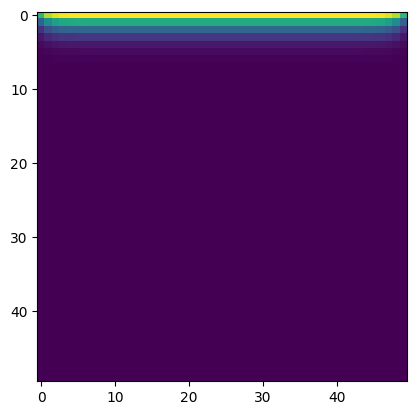

In [119]:
#plt.plot(phi_w_.values.native("x,y").numpy())
plt.imshow(phi_w.values.native("x,y").numpy())

In [124]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from DL_models.PINNS.utils import *

class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(4, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 1, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*0.01
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x[0]
  

#class composed_loss(object):

#from DL_models.PINNS.utils import x_grad

# def x_grad(u,x,i,n):
  """
  gradient of degree n wrt x for component i of u
  input:
  u and x are tensors with vectors object at dimension -1
  [b, n_vectors, vector_dimension]
  output:
  [b, n_vectors, input_vector_dimension]
  """


def composed_loss(p,x,conductivity=0.3):
  """
  u: [b x y p]
  x: [b x y (x y t)]
  """
  #p=rearrange(p,"b p x y-> b (x y) p")
  #x=rearrange(x,"b u x y-> b (x y) u")
  dpdt = x_grad(p,x,0,1)[...,2]
  x_1_grad = x_grad(p,x,0,1)[...,:2] # r
  con_tensor=torch.eye(2,2)*conductivity # [2, 2]
  k=torch.tensordot(con_tensor,x_1_grad,dims=([-1],[2]))
  x_2_grad = torch.sum(x_grad(p,x,0,1)[...,:2],axis=-1) # r

  return torch.abs(torch.mean(dpdt-k*x_2_grad))

In [125]:
st_model=simple_cnn_model().train()
optimizer=torch.optim.Adam(st_model.parameters(),lr=1e-4)

In [126]:
T=PINNS_based_SOL_trainer(
    field=phi_w,
    physical_model=diffusion_model,
    statistical_model=st_model,
    optimizer=optimizer,
    simulation_steps=50,
    time_step=0.5,
    loss=composed_loss
)

In [127]:
L=T.train(2)

epoch 0


KeyboardInterrupt: 

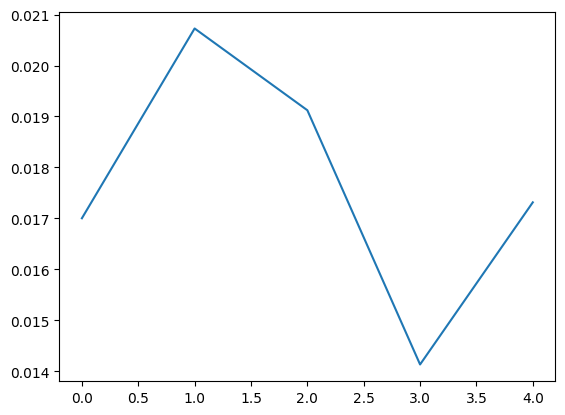

In [82]:
plt.plot(L)

## Reaction-diffusion

In [ ]:
from phi.torch.flow import *
from phi import math as math_phi
class diffusion_model(object):
  def __init__(self,field,dt,conductivity=0.3):
    self.field=field
    self.dt=dt
    self.conductivity=conductivity

  def step(self, v):
    lap = laplace(v, 
                  weights=self.conductivity, 
                  #gradient=gradient, 
                  order=2, 
                  implicit=math_phi.Solve,
                  #upwind=upwind,
                  #correct_skew=correct_skew
                  )
    return lap.with_extrapolation(v.boundary - v.boundary)  # remove constants from extrapolation
    #return diffuse.implicit(v, self.conductivity, self.dt)
args={"k":0.1}

In [ ]:
geo=UniformGrid(x=20, y=20,bounds=Box(x=1.0, y=1.0))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': tensor(0.01),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })
phi_w



model=diffusion_model(phi_w,0.1,0.3)

In [94]:
#phi_w.geometry=UniformGrid(x=20, y=20,bounds=Box(x=1.0, y=1.0))
phi_w.downsample(4)

Field[(xˢ=13, yˢ=13)]

## 